In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
import csv
import relatedness


glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

    
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)    


glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")


#Constants setup
max_hypothesis_length, max_evidence_length = 15, 15
vector_size =  50


def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

def sentence2sequence(sentence):
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            #print("hello")
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words


    
    
def split_data_into_scores():
    with open("sick_dataset_train.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            premise = (row["sentence_A"].lower())
            hypo = (row["sentence_B"].lower())
            sc=relatedness.sentence_similarity(premise,hypo)
            #print(sc)
            scores.append(sc)
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            labels.append(row["relatedness_score"])
            #scores.append(float(row["relatedness_score"]))

        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                      for x in evi_sentences])
                             
    return (hyp_sentences, evi_sentences), labels, scores 
 
data_feature_list, correct_labels, correct_score = split_data_into_scores()

C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [2]:
print(correct_score)

[0.9629629629629629, -0.05882352941176472, 0.8452380952380951, 0.8000000000000002, 0.7595238095238095, 0.8095238095238096, 0.6551467955603295, 0.6551467955603295, 0.6734782608695652, 0.6734782608695652, 0.6129658385093167, 1.0, 0.6981459250366813, 0.7582417582417582, 0.0, 0.7884615384615384, -0.21153846153846156, -0.29393939393939394, -0.4097222222222223, 0.9166666666666666, 0.875, 0.7741176470588236, 0.7741176470588236, 0.892156862745098, 0.8315789473684211, 0.7363408521303259, 0.9172932330827067, 0.8375, 0.9444444444444444, 0.9333333333333333, 0.7730994152046783, 0.7730994152046783, 0.7730994152046783, 0.6407407407407408, 0.4461970128636795, 1.0, -0.29166666666666663, 1.0, 0.8800000000000001, 0.7777777777777778, 0.5011655011655012, 0.7777777777777778, 1.0, 0.8941176470588236, 0.9166666666666666, 0.7428571428571429, 0.3894444444444445, 0.38376068376068373, 0.611111111111111, 0.9313725490196078, 0.0, -0.259920634920635, 0.8888888888888888, 0.7251461988304093, 1.0, 0.875, 0.931972789115

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import numpy as np


correct_score1 = np.array(correct_score,dtype=float)
correct_labels1 = np.array(correct_labels,dtype=float)

model = Sequential()
model.add(Dense(60, activation='sigmoid', input_dim=1, init='uniform'))
model.add(Dense(1, activation='linear'))
sgd = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=False)
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history = model.fit(correct_score1,correct_labels1,nb_epoch = 400, batch_size = 10,verbose = 0)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(60, activation="sigmoid", input_dim=1, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  from ipykernel import kernelapp as app


dict_keys(['loss', 'mse', 'mae'])


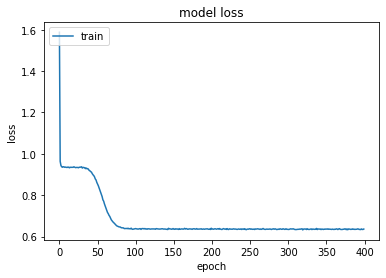

In [4]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [5]:
glove_zip_file1 = "glove.6B.zip"
glove_vectors_file1 = "glove.6B.50d.txt"

from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file1) and
    not os.path.isfile(glove_vectors_file1)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file1)

    
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)    


glove_wordmap1 = {}
with open(glove_vectors_file1, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap1[name] = np.fromstring(vector, sep=" ")


def sentence2sequence1(sentence):
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            #print("hello")
            if word in glove_wordmap1:
                rows.append(glove_wordmap1[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words



import csv
y_true=[]
with open("sick_dataset_train.txt","r") as data:
     dev = csv.DictReader(data, delimiter='\t')
     for row in dev:
        y_true.append(float(row["relatedness_score"]))


    
def split_data_into_scores1():
    evi_sentences = []
    hyp_sentences = []
    labels = []
    scores = []
    pair_id = []
    with open("sick_dataset_train.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        for row in train:
            #print(row["sentence1"])
            premise = (row["sentence_A"].lower())
            hypo = (row["sentence_B"].lower())
            sc=relatedness.sentence_similarity(premise,hypo)
            scores.append(sc)
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            #labels.append(row["relatedness_score"])
            #scores.append(float(row["relatedness_score"]))
            pair_id.append(row["pair_ID"])
            
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                      for x in evi_sentences])
                             
    return (hyp_sentences, evi_sentences), scores, pair_id #, np.array(scores)

data_feature_listt, correct_scoret, paid_idt = split_data_into_scores1()

correct_scoret=np.array(correct_scoret)
predict_relatedness = []
for i in range(0,4500):
    arr=model.predict(np.asarray(correct_scoret[i]).reshape(1,1))
    arrtolist=arr[0][0].tolist()    
    predict_relatedness.append(float(format(float(arrtolist),'.2f')))
output_DT = pd.DataFrame(data={"pair_ID":paid_idt,"Calculated Relatedness_score":predict_relatedness, "Given Relatedness Score":y_true})
output_DT.to_csv("relatedness.csv",index=False,quoting=3)

C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [6]:
output_DT

,pair_ID,Calculated Relatedness_score,Given Relatedness Score
0,1,4.25,4.5
1,2,3.48,3.2
2,3,3.66,4.7
3,5,3.44,3.4
4,9,3.23,3.7
...,...,...,...
4495,9993,3.44,1.1
4496,9997,2.53,1.0
4497,9998,2.31,1.0
4498,9999,2.15,1.2


In [7]:
print(y_true)
print(predict_relatedness)

[4.5, 3.2, 4.7, 3.4, 3.7, 4.0, 3.5, 3.2, 2.8, 3.7, 3.4, 4.9, 3.6, 3.8, 3.4, 4.9, 3.9, 3.415, 3.7, 4.4, 3.8, 3.5, 4.0, 2.9, 4.1, 2.5, 4.2, 4.4, 3.2, 3.635, 2.4, 2.6, 2.2, 3.0, 2.0, 5.0, 4.2, 3.0, 3.1, 1.7, 1.4, 1.5, 4.8, 3.8, 4.1, 4.3, 2.1, 3.0, 2.6, 3.2, 3.7, 2.6, 2.7, 2.3, 4.4, 2.6, 4.1, 3.4, 3.3, 3.8, 4.9, 3.7, 3.2, 3.1, 3.9, 3.4, 3.5, 3.6, 3.6, 3.9, 3.015, 2.7, 3.3, 2.9, 3.1, 3.2, 3.8, 3.7, 4.6, 3.7, 4.8, 3.3, 3.7, 2.7, 3.0, 4.0, 3.3, 3.5, 3.3, 3.9, 3.7, 1.9, 2.3, 1.6, 4.3, 4.0, 3.6, 2.5, 3.2, 4.3, 2.5, 2.5, 2.9, 2.4, 4.8, 3.6, 3.2, 3.8, 4.1, 3.2, 3.0, 3.3, 3.6, 3.0, 3.8, 3.4, 4.0, 4.4, 2.8, 2.9, 3.1, 4.4, 3.8, 3.0, 4.2, 4.3, 3.8, 4.5, 3.3, 3.9, 1.5, 1.3, 4.0, 2.6, 4.5, 4.6, 1.4, 4.3, 4.7, 3.7, 2.7, 3.8, 2.5, 2.8, 4.6, 4.3, 3.9, 3.2, 4.0, 4.5, 3.4, 4.1, 3.2, 4.3, 3.8, 4.4, 2.9, 2.6, 2.1, 2.0, 2.5, 1.6, 2.4, 3.8, 4.6, 4.8, 4.1, 3.7, 4.2, 2.6, 2.7, 3.1, 3.5, 4.7, 1.5, 3.2, 3.0, 3.5, 4.3, 3.2, 4.3, 3.2, 4.2, 4.3, 2.4, 1.9, 2.9, 3.7, 3.3, 4.7, 3.5, 4.0, 3.6, 2.3, 3.6, 3.0, 2.7, 3.5, 4.7

In [8]:
print("********************************************")
print ("Evaluation Measures")
from scipy import stats
correlation, p_value = stats.pearsonr(y_true, predict_relatedness)
print("Pearson Correlation")
print(correlation)
scorr, p = stats.spearmanr(y_true, predict_relatedness)
print("Spearman Correlation")
print(scorr)
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_true, predict_relatedness)
print("Mean Squared Error")
print(mse)
print("*********************************************")

********************************************
Evaluation Measures
Pearson Correlation
0.6323454184332175
Spearman Correlation
0.6251107784248787
Mean Squared Error
0.6307423166666667
*********************************************


In [9]:
import csv
y_true2=[]
with open("sick_dataset_dev.txt","r") as data:
     dev = csv.DictReader(data, delimiter='\t')
     for row in dev:
        y_true2.append(float(row["relatedness_score"]))


    
def split_data_into_scores2():
    evi_sentences = []
    hyp_sentences = []
    labels = []
    scores = []
    pair_id = []
    with open("sick_dataset_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        for row in train:
            #print(row["sentence1"])
            premise = (row["sentence_A"].lower())
            hypo = (row["sentence_B"].lower())
            sc=relatedness.sentence_similarity(premise,hypo)
            scores.append(sc)
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            #labels.append(row["relatedness_score"])
            #scores.append(float(row["relatedness_score"]))
            pair_id.append(row["pair_ID"])
            
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                      for x in evi_sentences])
                             
    return (hyp_sentences, evi_sentences), scores, pair_id #, np.array(scores)

data_feature_list2, correct_score2, paid_id2 = split_data_into_scores2()

correct_score2=np.array(correct_score2)
predict_relatedness2 = []
for i in range(0,500):
    arr=model.predict(np.asarray(correct_score2[i]).reshape(1,1))
    arrtolist=arr[0][0].tolist()    
    predict_relatedness2.append(float(format(float(arrtolist),'.2f')))
output_DT = pd.DataFrame(data={"pair_ID":paid_id2,"Calculated Relatedness_score":predict_relatedness2, "Given Relatedness Score":y_true2})

C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [10]:
output_DT

,pair_ID,Calculated Relatedness_score,Given Relatedness Score
0,4,3.25,3.6
1,24,2.53,3.4
2,105,3.51,3.8
3,116,2.53,2.9
4,119,3.88,4.2
...,...,...,...
495,9880,2.82,1.2
496,9931,4.02,3.0
497,9963,2.57,1.0
498,9975,2.13,1.0


In [11]:
print("********************************************")
print ("Evaluation Measures")
from scipy import stats
correlation, p_value = stats.pearsonr(y_true2, predict_relatedness2)
print("Pearson Correlation")
print(correlation)
scorr, p = stats.spearmanr(y_true2, predict_relatedness2)
print("Spearman Correlation")
print(scorr)
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_true2, predict_relatedness2)
print("Mean Squared Error")
print(mse)
print("*********************************************")

********************************************
Evaluation Measures
Pearson Correlation
0.6218503438542828
Spearman Correlation
0.6255549333527446
Mean Squared Error
0.62282805
*********************************************


In [12]:
def split_data_into_scores3():
    evi_sentences = []
    hyp_sentences = []
    labels = []
    scores = []
    pair_id = []
    with open("sick_dataset_test.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        for row in train:
            #print(row["sentence1"])
            premise = (row["sentence_A"].lower())
            hypo = (row["sentence_B"].lower())
            sc=relatedness.sentence_similarity(premise,hypo)
            scores.append(sc)
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_A"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence_B"].lower())[0]))
            #labels.append(row["relatedness_score"])
            #scores.append(float(row["relatedness_score"]))
            pair_id.append(row["pair_ID"])
            
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                      for x in evi_sentences])
                             
    return (hyp_sentences, evi_sentences), scores, pair_id #, np.array(scores)

data_feature_listt, correct_scoret, pair_idt = split_data_into_scores3()

correct_scoret=np.array(correct_scoret)
predict_relatedness3 = []
for i in range(0,4927):
    arr=model.predict(np.asarray(correct_scoret[i]).reshape(1,1))
    arrtolist=arr[0][0].tolist()    
    predict_relatedness3.append(float(format(float(arrtolist),'.2f')))

C:\Users\Shilpu\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [13]:
df = pd.DataFrame(data={"pair_ID":pair_idt,"Relatedness_score":predict_relatedness3})
df.to_csv("relatedness.csv",index=False,quoting=3)

In [14]:
df

,pair_ID,Relatedness_score
0,6,2.44
1,7,2.72
2,8,2.43
3,10,4.39
4,11,4.02
...,...,...
4922,9991,3.13
4923,9992,2.19
4924,9994,2.51
4925,9995,2.44


In [15]:
import pandas as pd

a = pd.read_csv("relatedness.csv")
b = pd.read_csv("entailment.csv")
b = b.dropna(axis=1)
merged = b.merge(a, on='pair_ID')
merged.to_csv("output.csv", index=False)

In [16]:
import csv
csv_file = 'output.csv'
txt_file = 'results.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()